# Tarea 2 - Kernels
## Librerías
Antes de comenzar, asegurarse que se tienen las siguentes librerías instaladas
se recomienda utilizar venv o virtualenv.

1. `pip install pillow`
2. `pip install matplotlib`
3. `pip install numpy`

## Instrucciones
En este ejercicio debes usar la imagen panda.png, la cual se encuentra en Canvas:
1. Transforma la imagen a tono de grises y trabaja con esta en los siguientes incisos. 
2. Investiga cómo se definen los filtros derivada (horizontal y vertical) Prewitt, Sobel y Scharr.
Aplica a la imagen de grises anterior los filtros Prewitt, Sobel y Scharr, para la detección de contornos.
Muestra cada una de las imágenes resultantes.

 NOTA: La implementación de estos kernels deben ser sin usar los métodos de algunas de las librerías.
Es decir, debes definirlos e implementarlas manualmente.    
 
3. Utiliza alguna de las librerías deseadas para implementar el método de Canny para la detección de bordes.
4. En este inciso deberás dibujar en la imagen a color panda.png, los vectores gradiente, ortogonales a los contornos de
la imagen de manera similar a como se muestra en el archivo 02_Fundamentos_y_Transformaciones.pdf, diapositiva 36.

Para calcular y aproximar el gradiente puedes utilizar cualquiera de los kernels derivada (Sobel, Prewitt o Scharr) que 
desees, para obtener las parciales con 𝑥 y con 𝑦. Además, para una mejor visualización de los vectores gradientes, 
puedes dibujar solamente un porcentaje de dichos vectores gradientes y solo aquellos que tengan las magnitudes más 
significativas. Asimismo, puedes estandarizar la magnitud de los vectores gradientes a un valor constante que desees.

### Import statements, Jupyter magicy definimos constantes

In [4]:
%matplotlib inline

In [19]:
from enum import Enum
from math import floor
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

IMAGE_PATH = "resources/panda.png"

class PaddingMode(Enum):
    CEROS = "constant"
    REPLICA = "edge"
    SIMETRIA = "symmetric"
    CICLICO = "wrap"

### Funciones auxiliares

In [28]:
def apply_kernel(image, kernel, is_convolution: bool=False, padding_mode: PaddingMode = PaddingMode.CEROS):
    # We are assuming the kernel will be a square with a single center, i.e. size is of odd length
    if is_convolution:
        kernel = np.rot90(kernel, k=2)
    
    # Calculate the padding
    pad_width = floor(len(kernel) / 2)
    
    # Add padding to make sure the kernel is uniformly applied
    if padding_mode == PaddingMode.CEROS:
        image = np.pad(image, pad_width=pad_width, mode=PaddingMode.CEROS.value, constant_values=0)
    else:
        image = np.pad(image, pad_width=pad_width, mode=padding_mode.value)
    
    image = image.astype("int32")
    # TODO
    # Apply the kernel to each of the values
    


### 1. Cargar la imagen

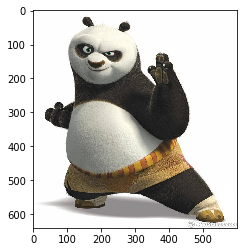

In [8]:
panda = Image.open(IMAGE_PATH)
plt.imshow(panda)

#### 1.1 Aplicamos un cambio a grises NTSC

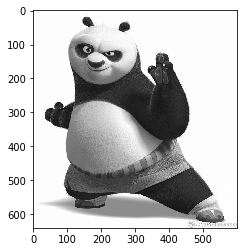

In [16]:
panda_rgb_values = np.array(panda)

# Apply the greyscale by multiplying the R, G and B values of the image by the NTSC factors
panda_grey_values = np.floor(np.dot(panda_rgb_values[...,:3], [0.2989, 0.5870, 0.1140]))
panda_grey_values = panda_grey_values.astype("int32")
panda_grey_image = Image.fromarray(panda_grey_values)

plt.imshow(panda_grey_image)

### 2.1. Aplicamos Prewitt

### 2.2. Aplicamos Sobel

### 2.3. Aplicamos Scharr

### 3. Aplicamos Canny

### 4. Mostramos la gradiente en la imagen a color